# Imports

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
import cv2 as cv
from matplotlib import pyplot as plt
from resnet_152 import resnet152_model

Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config# Try this for foam liu

gpu_options {
  allow_growth: true
}

In [3]:
# For folder processing
from scipy.io import loadmat
import os
import tarfile
import shutil
from tqdm import tqdm
import requests

# For Image Processing and Display
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline 

# For Visualization
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)

# For data processing
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm

# For machine learning
from sklearn.model_selection import train_test_split

# For Training Image Classification Model
from keras.models import load_model, Sequential
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

In [4]:
!pwd

/home/meraldoantonio/Desktop/Car-classifier


# Preprocessing

## Downloading the Datasets and Their Labels

In [9]:
def download_file(target_url, target_directory):
    """
    Function:
        - Creates a relative path `target_directory` in the current working directory if it doesn't exist yet
        - Downloads a file from `target_url` and puts it into the `target_directory`
        
    Arguments:
        - target_url (str): source URL of the file to be downloaded
        - target_directory (str): relative path of the folder into which the file is to be downloaded
    """
    
    # Get the filename from the target_url
    filename = target_url.split(os.path.sep)[-1]
    
    # Construct the target_path of the file
    target_path = os.path.join(target_directory,filename)
    
    # If the file has already been downloaded in the correct directory, terminate function
    if os.path.exists(target_path):
        print(f"The file '{filename}' has already been downloaded into '{target_directory}'")
        return
    
    # If the target_folder doesn't exist yet, create it
    if not os.path.exists(target_directory):
        os.mkdir(target_directory)
        print(f"Created a new folder at '{target_directory}'")
        
    # Download the file into the target_folder
    print(f"Downloading '{filename}' from '{target_url}', please wait...")
    chunk_size = 1024
    r = requests.get(target_url, stream = True)
    size = int(r.headers['content-length'])
    print(f"File size = {size/chunk_size} KB.")    
    with open(target_path, 'wb') as f:
        for data in tqdm(iterable = r.iter_content(chunk_size = chunk_size),total = size/chunk_size, unit = 'KB'):
            f.write(data)
    
    
    print(f"The file '{filename}' has been downloaded into '{target_directory}'")
    return

In [10]:
train_url = "http://imagenet.stanford.edu/internal/car196/cars_train.tgz"
devkit_url = "https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz"
target_directory = "./tgz"

In [11]:
download_file(train_url, target_directory)

The file 'cars_train.tgz' has already been downloaded into './tgz'


In [12]:
download_file(devkit_url, target_directory)

The file 'car_devkit.tgz' has already been downloaded into './tgz'


## Unzipping the Datasets

In [13]:
def extract_dataset(source_path, target_directory):
    """
    Function:
        - Unzips the tar file in `source_path` into `target_directory`
        
    Arguments:
        - source_path (str): relative path of the file to be unzipped
        - target_directory (str): relative path of the directory into which the tar file will be unzipped
    """
    # Extraction step
    tar = tarfile.open(source_path)
    tar.extractall(target_directory)
    tar.close()
    
    # Count the number of files/subfolders contained in the target_directory
    files_list = [file for file in os.listdir(target_directory)]
    print(f"Extraction complete!")
    print(f"'{source_path}' has been unzipped into '{target_directory}'; this directory now has {len(files_list)} files/subfolders")

In [14]:
extract_dataset("./tgz/cars_train.tgz", "./data_download")

Extraction complete!
'./tgz/cars_train.tgz' has been unzipped into './data_download'; this directory now has 1 files/subfolders


In [15]:
extract_dataset("./tgz/car_devkit.tgz", "./metadata")

Extraction complete!
'./tgz/car_devkit.tgz' has been unzipped into './metadata'; this directory now has 1 files/subfolders


## Creating the`metadata`  DataFrame  that Stores Metadata of the Images

In [136]:
def create_metadata_dataframe(path_to_cars_meta_mat = './metadata/devkit/cars_meta.mat', 
                              path_to_cars_train_annos_mat = './metadata/devkit/cars_train_annos.mat'):
    
    """
    Function:
        - Creates a dataframe from the two zipped metadata files provided as part of the downloaded Cars dataset;
          this dataframe will contain information about each image in the dataset, including file name, bounding box coordinates and car class
        
    Arguments:
        - path_to_cars_meta_mat (str): relative path to the file 'cars_meta.mat' unzipped from 'car_devkit.tgz'
        - path_to_cars_train_annos_mat (str): relative path to the file 'cars_trains_annos.mat' unzipped from 'car_devkit.tgz'
    Returns:
        - metadata (pd.DataFrame): a dataframe containing the metadata of the downloaded images
    """
    
    # Load the matlab file that contains the complete list of class names
    original_dict_metadata = loadmat(path_to_cars_meta_mat)
    
    # Create a dictionary `dict_classnumber_classname` that maps the class numbers to class names
    dict_classnumber_classname = {int(index+1):classname[0] for index, classname in enumerate(original_dict_metadata["class_names"][0])}
    
    # Load the matlab file that contains the metadata (bounding box details and class details) for each training sample
    original_dict_traindata = loadmat(path_to_cars_train_annos_mat)
    
    # Create an empty dictionary `dict_filename_metadata` that maps the file names and metadata 
    dict_filename_metadata = {}

    # Populate `dict_filename_metadata` by looping through `original_dict_traindata`
    dict_filename_metadata = {image[5][0]:{"bbox_xmin": image[0][0][0], "bbox_ymin": image[1][0][0],"bbox_xmax": image[2][0][0],"bbox_ymax": image[3][0][0],"classnumber": image[4][0][0], "classname": dict_classnumber_classname[image[4][0][0]]} for image in original_dict_traindata["annotations"][0]}
    
    # Convert `dict_filename_metadata` into a dataframe
    metadata = pd.DataFrame.from_dict(data = dict_filename_metadata, orient = "index")
    
    # The "/" in 'Ram C/V Cargo Van Minivan 2012' turns out to be problematic so remove it
    metadata.loc[metadata["classname"] == 'Ram C/V Cargo Van Minivan 2012', "classname"] = "Ram CV Cargo Van Minivan 2012"
    
    return metadata

In [137]:
metadata = create_metadata_dataframe(path_to_cars_meta_mat = './metadata/devkit/cars_meta.mat', 
                              path_to_cars_train_annos_mat = './metadata/devkit/cars_train_annos.mat')

In [139]:
metadata.shape

(8144, 6)

## Splitting the `metadata` DataFrame into Training, Validation and Testing Sets

In [144]:
def train_valid_test_split(metadata = metadata, 
                           train_size = 0.6, 
                           valid_size = 0.3):
    
    """
    Function:
        - Assign specified portions of the metadata dataframe into training, validation and testing sets
    
    Arguments: 
        - metadata (pd.DataFrame): a dataframe containing the metadata of the downloaded images
        - train_size (float): the portion of the dataset to be assigned to the training set
        - valid_size (float): the portion of the dataset to be assigned to the validation set
        
    Returns:
        - final_df (pd.DataFrame): the metadata dataframe with a new column `category` that categorizes each sample into either the training, validation or testing set
    """
    
    assert train_size + valid_size <= 1, "training size + validation size has to be <= 1!"
    
    print(f"Splitting the dataframe into training, validation and testing (holdout) set with a ratio of {train_size:.2f} : {valid_size:.2f} : {1-train_size-valid_size:.2f}")
    
    # Split the df into training set and validation + testing set
    df_train, df_valid_test = train_test_split(metadata, train_size = train_size, random_state = 88, stratify = metadata["classnumber"])
    df_train = df_train.assign(category = "train")

    
    # Split the validation + testing set into validation set and testing set
    test_size = 1 - train_size - valid_size
    valid_size_adjusted = valid_size/(valid_size + test_size)
    
    df_valid, df_test = train_test_split(df_valid_test, train_size = valid_size_adjusted, random_state = 88, stratify = df_valid_test["classnumber"])
    df_valid = df_valid.assign(category = "valid")
    df_test = df_test.assign(category = "test")
    
    # Combine the three dataframes
    df_final = pd.concat([df_train, df_valid, df_test], axis = 0)
    
    total = metadata.shape[0]
    train = df_final["category"].value_counts()["train"]
    valid = df_final["category"].value_counts()["valid"]
    test = df_final["category"].value_counts()["test"]
    
    print()
    print(f"Out of {total:,} samples in the dataframe, \n{train:,} were assigned to the training set, \n{valid:,} to the validation set... \n...and {test:,} to the testing (holdout) set")
    return df_final

In [145]:
metadata = train_valid_test_split(metadata = metadata, train_size = 0.6, valid_size = 0.3)

Splitting the dataframe into training, validation and testing (holdout) set with a ratio of 0.60 : 0.30 : 0.10

Out of 8,144 samples in the dataframe, 
4,886 were assigned to the training set, 
2,443 to the validation set... 
...and 815 to the testing (holdout) set


## Visualizing the Distribution of the Datset

In [146]:
counts = metadata.groupby('classname')['classnumber'].count()
trace = go.Bar(x = counts.index, y = counts.values)
data = [trace]
layout = go.Layout(title = "Number of Samples per Class",
                  xaxis = {
                            'categoryorder': 'array',
                            'categoryarray': [x for _, x in sorted(zip(counts.values,counts.index))],
                            'showticklabels': False})
                           
figure = go.Figure(data = data, layout = layout)
iplot(figure)

## Inspecting An Image

In [161]:
def insert_bounding_box(image,
                        bounding_box_coordinates,
                        color=(0,0,255),
                        thickness=3,
                        use_normalized_coordinates=True):
    """
    Function:
        - Adds a bounding box to the numpy representation of an image.
        - The bounding box coordinates can be specified in either absolute (pixel) or normalized coordinates.

    Arguments:
        - image (np.ndarray): a numpy representation of the image
        - bounding_box_coordinates (tuple): a tuple containing (ymin, xmin, ymax, xmax) of the bounding box.
        - color (str): string representation of the color of the bounding box. Default is 'red'.
        - thickness (int): line thickness of the bounding box. Default value is 4.
        - use_normalized_coordinates (bool): If True (default), treat coordinates as relative to the image dimension.  Otherwise treat
          coordinates as absolute.
          
    Returns:
        - image_with_bounding_box (np.ndarray): a numpy representation of the image with bounding box
    
    """
    # Get the image's width and height
    (height, width, _) = image.shape

    # Unpack the bounding box coordinates
    ymin,xmin,ymax,xmax = bounding_box_coordinates

    # If the coordinates are normalized, get the default value of the coordinates
    if use_normalized_coordinates:
        (xmin,xmax,ymin,ymax) = (xmin * width, xmax * width, ymin * height, ymax * height)
   
    # Draw the bounding box
    image_with_bounding_box = cv.rectangle(img = image,
                                            pt1 = (int(xmin),int(ymin)),
                                            pt2 = (int(xmax),int(ymax)),
                                            color = (255,0,0),
                                            thickness = 3)
    # Return the modified np representation of the image into which the bounding box has been drawn
    return image_with_bounding_box

In [162]:

def show_image_from_directory(directory = "./data_download/cars_train", 
                               index = 0, 
                               metadata = metadata):
    """
    Function: 
        - show a car image in a folder, along with its preprocessed versions
    Arguments:
        - directory (str): relative path to the folder that contains the images
        - index (int): the index of the image to be shown
        - metadata (pd.DataFrame): a dataframe containing the metadata of the downloaded images
    """
    
    # Get an image from the directory
    image_list = os.listdir(directory)
    filename = image_list[index]
    original_image_bgr = cv.imread(os.path.join(directory,filename))

    
    # Using the metadata dataframe provided, print the image's metadata
    print(f"Index: {index}")
    print(f"Filename: {filename}")
    classname = metadata.loc[filename,["classname"]].values[0]
    print(f"Car class: {classname}")
    print("="*80)
    width, height,_ = original_image_bgr.shape
    print(f"Original width: {width}, original height: {height}")
    xmin,ymin,xmax,ymax = metadata.loc[filename,["bbox_xmin","bbox_ymin","bbox_xmax","bbox_ymax"]].values
    print(f"Bounding box position (absolute) - xmin: {xmin} | ymin: {ymin} | xmax: {xmax} | ymax: {ymax}")
    print("="*80)
    
    # The preprocessing steps
    original_image_rgb = cv.cvtColor(original_image_bgr, cv.COLOR_BGR2RGB) 
    image_with_bounding_box = insert_bounding_box(original_image_rgb.copy(), (ymin, xmin, ymax, xmax), use_normalized_coordinates=False)
    cropped_image = original_image_rgb[ymin:ymax, xmin:xmax] 
    resized_image = cv.resize(cropped_image, (224, 224))
    
    # Visualize the original image as well as the three preprocessed images
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
    ax1.imshow(image_with_bounding_box, interpolation='nearest')
    ax1.set_title("1. Original Image with Bounding Box")
    ax2.imshow(cropped_image, interpolation='nearest')
    ax2.set_title("2. Cropped Image")
    ax3.imshow(resized_image, interpolation='nearest')
    ax3.set_title("3. Resized Image (224 x 224 pixels)")
    plt.show()

Index: 10
Filename: 05435.jpg
Car class: Audi TT Hatchback 2011
Original width: 178, original height: 283
Bounding box position (absolute) - xmin: 3 | ymin: 39 | xmax: 281 | ymax: 149


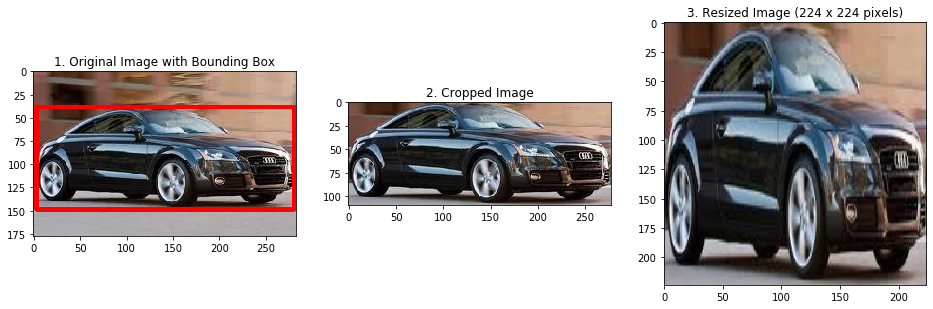

In [163]:
show_image_from_directory(index = 10)

Index: 12
Filename: 05037.jpg
Car class: Hyundai Veloster Hatchback 2012
Original width: 461, original height: 728
Bounding box position (absolute) - xmin: 111 | ymin: 123 | xmax: 657 | ymax: 436


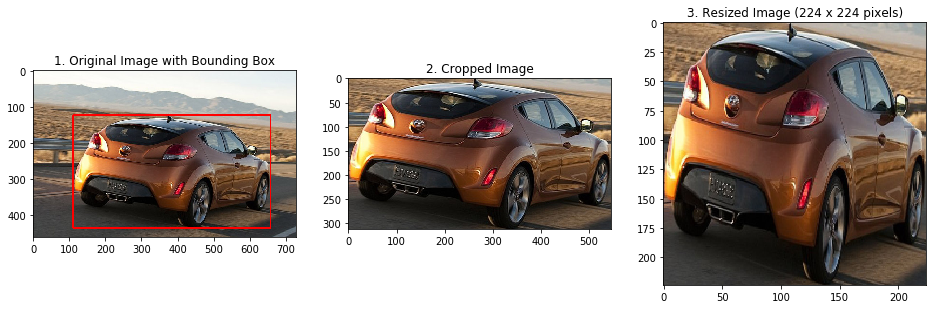

In [165]:
show_image_from_directory(index = 12)

## Cropping and Resizing Raw Images 

In [174]:

def crop_and_resize_images(source_directory = "./data_download/cars_train", 
                           target_directory = "./data_preprocessed", 
                           metadata = metadata):
    """
    Function: 
        - Crop and resize images in the source_directory and place the preprocessed images in the target_directory
    Arguments:
        - source_directory (str): relative path of the directory containing the images to be preprocessed
        - target_directory (str): relative path of the directory into which the preprocessed images are to be placed
        - metadata (pd.DataFrame): a dataframe containing the metadata of the downloaded images
    """
    
    image_list = os.listdir(source_directory)
    length_image_list = len(image_list)
    print(f"There are {length_image_list:,} images to preprocess in `{source_directory}`.")
    print("Preprocessing...")
    
    # If target_directory doesn't exist, create it
    if not os.path.exists(target_directory):
        os.mkdir(target_directory)
         
    # Preprocess images in the source_path and place them in destination_path
    for index, filename in tqdm(enumerate(image_list)):
        
        xmin,ymin,xmax,ymax = metadata.loc[filename,["bbox_xmin","bbox_ymin","bbox_xmax","bbox_ymax"]].values
        original_image_bgr = cv.imread(os.path.join(source_directory,filename))
        cropped_image = original_image_bgr[ymin:ymax, xmin:xmax] 
        resized_image = cv.resize(cropped_image, (224, 224))

        cv.imwrite(os.path.join(target_directory,filename), resized_image)
    print(f"{length_image_list:,} images have been preprocessed and placed in `{target_directory}`")

In [175]:
crop_and_resize_images(source_directory = "./data_download/cars_train", target_directory = "./data_preprocessed", metadata = metadata)

23it [00:00, 219.29it/s]

There are 8,144 images to preprocess in `./data_download/cars_train`.
Preprocessing...


8144it [00:44, 184.18it/s]

8,144 images have been preprocessed and placed in `./data_preprocessed`


## Sorting the Images to Appropriate Folders and Subfolders

In [178]:
def sort_images(directory = "./data_preprocessed", metadata = metadata):
    """
    Function:
        - Create folders `train`, `valid`  and `test` inside `directory`
        - In each of these three folders, create 196 subfolders that correspond to the 196 car classes
        - Sort images in the `directory` into their appropriate subfolders
    Argument:
        - metadata (pd.DataFrame): a dataframe containing the metadata of the downloaded images
    """   
    
    # Create folders `train`, `valid`  and `test` inside `directory` if they don't exist yet
    folders = metadata.category.unique()
    for folder in folders:
        if not os.path.exists(os.path.join(directory, folder)):
            os.makedirs(os.path.join(directory, folder))
            
        # Inside `train`, `valid`  and `test` subfolders, create one subfolder for every unique car class            
        for classname in metadata.classname.unique():
            if not os.path.exists(os.path.join(directory, folder, classname)):
                os.makedirs((os.path.join(directory, folder, classname)))
    
        # Sort images in the `directory` into their appropriate subfolders
        for filename in metadata.loc[metadata["category"] == folder,:].index:
            classname = metadata.loc[filename, "classname"]
            source_path = os.path.join(directory, filename) # example source_path: ./data_preprocessed/00001.jpg
            target_path = os.path.join(directory, folder, classname, filename) # example target_path: ./data_preprocessed/train/Acura RL Sedan 2012/00001.jpg
            shutil.move(source_path, target_path)


In [179]:
sort_images(directory = "./data_preprocessed", metadata = metadata)

In [180]:
!tree ./data_preprocessed

./data_preprocessed
├── test
│   ├── Acura Integra Type R 2001
│   │   ├── 00878.jpg
│   │   ├── 01911.jpg
│   │   ├── 04691.jpg
│   │   ├── 05671.jpg
│   │   └── 05916.jpg
│   ├── Acura RL Sedan 2012
│   │   ├── 03011.jpg
│   │   ├── 05259.jpg
│   │   └── 07897.jpg
│   ├── Acura TL Sedan 2012
│   │   ├── 05545.jpg
│   │   ├── 05967.jpg
│   │   ├── 06328.jpg
│   │   └── 07663.jpg
│   ├── Acura TL Type-S 2008
│   │   ├── 02240.jpg
│   │   ├── 03467.jpg
│   │   ├── 06614.jpg
│   │   └── 07445.jpg
│   ├── Acura TSX Sedan 2012
│   │   ├── 00700.jpg
│   │   ├── 02457.jpg
│   │   ├── 02670.jpg
│   │   └── 04484.jpg
│   ├── Acura ZDX Hatchback 2012
│   │   ├── 01468.jpg
│   │   ├── 04631.jpg
│   │   ├── 06269.jpg
│   │   └── 07061.jpg
│   ├── AM General Hummer SUV 2000
│   │   ├── 01832.jpg
│   │   ├── 01918.jpg
│   │   ├── 02145.jpg
│   │   ├── 02311.jpg
│   │   └── 07487.jpg
│   ├── Aston Martin V8 Vantage Convertible 2012
│   │   ├── 01283.jpg
│   │   ├── 02377.jpg
│   │   ├── 04396.jpg
│ 

    ├── Ford F-150 Regular Cab 2012
    │   ├── 01131.jpg
    │   ├── 01175.jpg
    │   ├── 02444.jpg
    │   ├── 02805.jpg
    │   ├── 04083.jpg
    │   ├── 04164.jpg
    │   ├── 04278.jpg
    │   ├── 04699.jpg
    │   ├── 05390.jpg
    │   ├── 06283.jpg
    │   ├── 06463.jpg
    │   ├── 06464.jpg
    │   └── 07732.jpg
    ├── Ford F-450 Super Duty Crew Cab 2012
    │   ├── 00073.jpg
    │   ├── 00074.jpg
    │   ├── 00231.jpg
    │   ├── 01280.jpg
    │   ├── 03240.jpg
    │   ├── 04607.jpg
    │   ├── 05491.jpg
    │   ├── 05512.jpg
    │   ├── 06670.jpg
    │   ├── 06775.jpg
    │   ├── 06814.jpg
    │   ├── 06817.jpg
    │   └── 07083.jpg
    ├── Ford Fiesta Sedan 2012
    │   ├── 00811.jpg
    │   ├── 02133.jpg
    │   ├── 02834.jpg
    │   ├── 04036.jpg
    │   ├── 04068.jpg
    │   ├── 04536.jpg
    │   ├── 04985.jpg
    │   ├── 05697.jpg
    │   ├── 06223.jpg
    │   ├── 07117.jpg
    │   ├── 07446.jpg
    │   ├── 08054.jpg
    │   └── 08113.jpg
    ├── Ford Focus Sedan 2007
 

In [ ]:
## Not yet checked
def combine_augmented_folder(directory1 = "./data_cropped_preprocessed2", directory2 = "./data_preprocessed/train"):
    
     for root, directories, files in tqdm(os.walk(directory1, topdown=False)):
        for i, file in tqdm(enumerate(files)):
            source_path = os.path.join(root, file)
            car_class = source_path.split(os.path.sep)[-2]
            destination_path = os.path.join(directory2,car_class, file)
            shututil.copyfile(source_path, destination_path)

In [ ]:
#combine_augmented_folder()

# Model

## YOLO

In [ ]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03' + '/frozen_inference_graph.pb'


In [ ]:
def build_localization_model(path_to_frozen_graph = PATH_TO_FROZEN_GRAPH):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

In [ ]:
detection_graph = build_localization_model()

In [ ]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,image_width):
  """Transforms the box masks back to full image masks.

  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.

  Args:
    box_masks: A tf.float32 tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.

  Returns:
    A tf.float32 tensor of size [num_masks, image_height, image_width].
  """
  # TODO(rathodv): Make this a public function.
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""
    def transform_boxes_relative_to_boxes(boxes, reference_boxes):
      boxes = tf.reshape(boxes, [-1, 2, 2])
      min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
      max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
      transformed_boxes = (boxes - min_corner) / (max_corner - min_corner)
      return tf.reshape(transformed_boxes, [-1, 4])

    box_masks_expanded = tf.expand_dims(box_masks, axis=3)
    num_boxes = tf.shape(box_masks_expanded)[0]
    unit_boxes = tf.concat(
        [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
    reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)
    return tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reverse_boxes,
        box_ind=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        extrapolation_value=0.0)
  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], dtype=tf.float32))
  return tf.squeeze(image_masks, axis=3)


In [ ]:
def run_inference_for_single_image(image, graph = detection_graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [ ]:
def insert_bounding_box(image_np,
                        bounding_box_coordinates,
                        color='red',
                        thickness=4,
                        use_normalized_coordinates=True):
    """
    Function: 
        - Adds a bounding box to the numpy representation of an image. 
        - The bounding box coordinates can be specified in either absolute (pixel) or normalized coordinates.

    Arguments:
        - image_np (nd_array): a numpy representation of the image
        - bounding_box_coordinates (tuple): a tuple containing (ymin, xmin, ymax, xmax) of the bounding box.
        - color (str): string representation of the color of the bounding box. Default is 'red'.
        - thickness (int): line thickness of the bounding box. Default value is 4.
        - use_normalized_coordinates (bool): If True (default), treat coordinates as relative to the image dimension.  Otherwise treat
          coordinates as absolute.
    """
    # Get the PIL representation of the image_np
    image_pil = Image.fromarray(image_np, mode = "RGB")

    # Isolate image dimensions
    im_width, im_height = image_pil.size
    
    # Unpack the coordinates
    ymin,xmin,ymax,xmax = bounding_box_coordinates
    
    # Get the borders of the bounding box
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)

    # Draw a new PIL image that includes the bounding box
    draw = ImageDraw.Draw(image_pil)
    draw.line([(left, top), (left, bottom), (right, bottom),(right, top), (left, top)], width=thickness, fill=color)
    np.copyto(image_np, np.array(image_pil))
    
    # Return the modified np representation of the image into which the bounding box has been drawn
    return image_np

In [ ]:
def predict_bounding_box(image_np):
    """
    Function: 
        - Uses the supplied model to localize the most prominently displayed car in an image
    Arguments:
        - image_np (nd_array): a numpy representation of the car image
    Returns
    if detect car:
        - best_bounding_box_coordinates (tuple): a tuple of coordinates corresponding to the location of the most prominently displayed car.
                                     The bounding box coordinates (ymin,xmin, ymax,xmax) are specified in normalized coordinates.
        - best_bounding_box_probability (float): the confidence score of the best_bounding_box actually containing a car
    if doesn't detect any car:
        - None
    """
    
    # Get its width and height
    (im_width, im_height, _) = image_np.shape
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection step
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    
    try:
        # Get bounding boxes that relate to cars
        car_bounding_boxes = output_dict["detection_boxes"][output_dict["detection_classes"] == 3]

        def calculate_area(bounding_box):
            ymin,xmin, ymax,xmax = bounding_box
            area = (ymax - ymin)*(xmax - xmin)
            return area

        # Get bounding box with the largest area
        best_bounding_box_index = np.array([(calculate_area(car_bounding_box)) for car_bounding_box in car_bounding_boxes]).argmax()
        best_bounding_box_coordinates = output_dict["detection_boxes"][best_bounding_box_index]
        
        best_bounding_box_probability = output_dict["detection_scores"][best_bounding_box_index]
        

        return best_bounding_box_coordinates, best_bounding_box_probability
    
    except:
        print("The model doesn't detect any car in the picture!")
        print("The function will return `None`.")
        return None, None
    
    

In [ ]:
image_path = './sample_images_from_each_class/Audi 100 Sedan 1994.jpg'

image = Image.open(image_path)

# Get its width and height
(im_width, im_height) = image.size

# Get its np representation
image_np_original = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

plt.figure(figsize=(9,12))
plt.imshow(image_np_original)

## Failed Model

In [ ]:
def load_untrained_transfer_model():
    """
    If model isn't saved - download model, save it to current directory and return it
    If model already exists, simply return the model
    """
    model_path = "./model/Untrained_transfer.h5"
    if os.path.exists(model_path):
        print(f"Retrieving saved model from {model_path}")
        untrained_transfer_model = load_model(model_path)
        print("Saved model retrieved!")
        return untrained_transfer_model
    else:
        ## Build model
        print("Downloading and building model...")
        untrained_transfer_model = Sequential()
        untrained_transfer_model.add(ResNet50(include_top = False, pooling = "avg", weights = "imagenet"))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.3))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.3))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.3))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.3))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.3))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.3))
        untrained_transfer_model.add(Dense(196, activation = "softmax"))
        
        untrained_transfer_model.layers[0].trainable = False
        
        ## Save model
        print(f"Model built and saved in {model_path}")
        untrained_transfer_model.save(model_path)
        return untrained_transfer_model

In [ ]:
#transfer_model = load_untrained_transfer_model()

In [ ]:
#transfer_model.summary()

In [ ]:
"""adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # Try adam, also learning rate maybe too low?
transfer_model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])"""

In [ ]:
#df_train["preprocessed_np_image"] = df_train["np_image"].apply(lambda x: preprocess_image(x))

In [ ]:
"""
train_data = './data_preprocessed/train'
valid_data = './data_preprocessed/valid'
n_train_samples = len(os.listdir(train_data))
n_valid_samples = len(os.listdir(valid_data))
verbose = 1
batch_size = 2 # Originally 16
n_epochs = 1000
patience = 100
"""

In [ ]:
"""
train_ImageDataGenerator = ImageDataGenerator(rotation_range=20.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True)


valid_ImageDataGenerator = ImageDataGenerator()
"""

In [ ]:

"""
train_generator = train_ImageDataGenerator.flow_from_directory(train_data, (224, 224), batch_size=batch_size,
                                                     class_mode='categorical')
valid_generator = valid_ImageDataGenerator.flow_from_directory(valid_data, (224, 224), batch_size=batch_size,
                                                     class_mode='categorical')
valid_ImageDataGenerator = ImageDataGenerator()
"""

In [ ]:
"""

# define callbacks
#tensor_board = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

log_file_path = 'logs/training.log'
csv_logger = CSVLogger(log_file_path, append=False)

early_stop = EarlyStopping('val_acc', patience=patience)

reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)

trained_models_path = 'model/model'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)


callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

"""

## Naive Model

Model was taken from https://github.com/flyyufelix/cnn_finetune/blob/master/resnet_152.py

In [ ]:
width, height = 224, 224
num_channels = 3
train_folder = 'data_preprocessed/train'
valid_folder = 'data_preprocessed/valid'
num_classes = 196
num_train_samples = len(os.listdir(train_folder))
num_valid_samples = len(os.listdir(valid_folder))
verbose = 1
batch_size = 16
num_epochs = 50000
patience = 200

In [ ]:
model = resnet152_model(height, width, num_channels, num_classes)

In [ ]:
train_data_gen = ImageDataGenerator(rotation_range=25.,
                                    shear_range=0.1,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    fill_mode="nearest")

# Don't augment the validation data!
valid_data_gen = ImageDataGenerator()

In [ ]:
tensor_board = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
log_file_path = 'logs/training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_acc', patience=patience)
reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)
trained_models_path = 'models/model_final_2_'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]


In [ ]:
train_generator = train_data_gen.flow_from_directory(train_folder, (width, height), batch_size=batch_size,
                                                     class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(valid_folder, (width, height), batch_size=batch_size,
                                                     class_mode='categorical')


In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples / batch_size,
        validation_data=valid_generator,
        validation_steps=num_valid_samples / batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose)

## Retrained Classifier Model

In [ ]:


# What made it work? We' ll never know
# But it may be this: pip install update tensorflow-gpu==1.13.1


In [ ]:
def load_good_model():
    model_weights_path = 'models/model.96-0.89.hdf5'
    img_width, img_height = 224, 224
    num_channels = 3
    num_classes = 196
    model = resnet152_model(img_height, img_width, num_channels, num_classes)
    model.load_weights(model_weights_path, by_name=True)
    return model

In [ ]:
good_model = load_good_model()

In [ ]:
width, height = 224, 224
num_channels = 3
train_folder = 'data_preprocessed/train'
valid_folder = 'data_preprocessed/valid'
num_classes = 196
num_train_samples = len(os.listdir(train_folder))
num_valid_samples = len(os.listdir(valid_folder))
verbose = 1
batch_size = 16
num_epochs = 50000
patience = 200

In [ ]:
tensor_board = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
log_file_path = 'logs/training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_acc', patience=patience)
reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 5), verbose=1)
trained_models_path = 'models/model_final_2_'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]


In [ ]:
train_data_gen = ImageDataGenerator(rotation_range=25.,
                                    shear_range=0.1,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    fill_mode="nearest")

# Don't augment the validation data!
valid_data_gen = ImageDataGenerator()

In [ ]:
train_generator = train_data_gen.flow_from_directory(train_folder, (width, height), batch_size=batch_size,
                                                     class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(valid_folder, (width, height), batch_size=batch_size,
                                                     class_mode='categorical')


In [ ]:
history2 = good_model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples / batch_size,
        validation_data=valid_generator,
        validation_steps=num_valid_samples / batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose)

In [ ]:
img_width, img_height = 224, 224
num_channels = 3
train_data = 'data_preprocessed/train'
valid_data = 'data_preprocessed/valid'
num_classes = 196
num_train_samples = 6515
num_valid_samples = 1629
verbose = 1
batch_size = 16
num_epochs = 100000
patience = 50

In [ ]:
# fine tune the model

history = good_model.fit_generator(
    generator = train_generator,
    steps_per_epoch = num_train_samples / batch_size,
    validation_data = valid_generator,
    validation_steps = num_valid_samples / batch_size,
    epochs = num_epochs,
    callbacks = callbacks,
    verbose = 1)


In [ ]:
"""
sample_model = load_model("./model/model.03-0.02.hdf5")
"""

In [ ]:
"""
predictions = sample_model.predict_generator(generator = valid_generator, 
                                             steps = 50)
"""

### Loading Model

In [ ]:
import cv2 as cv
from resnet_152 import resnet152_model

In [ ]:
def load_good_model():
    model_weights_path = 'models/model.96-0.89.hdf5'
    img_width, img_height = 224, 224
    num_channels = 3
    num_classes = 196
    model = resnet152_model(img_height, img_width, num_channels, num_classes)
    model.load_weights(model_weights_path, by_name=True)
    return model

In [ ]:
model_good = load_good_model()

### Training Model

In [ ]:
"""
history = model_good.fit_generator(
    generator = train_generator,
    steps_per_epoch = n_train_samples / batch_size,
    validation_data = valid_generator,
    validation_steps = n_valid_samples / batch_size,
    epochs = n_epochs,
    callbacks = callbacks,
    verbose = 1)
    
"""

# Testing Model

In [ ]:

import random
import scipy

from keras.preprocessing import image

In [ ]:


cars_meta = scipy.io.loadmat('./metadata/devkit/cars_meta.mat')

In [ ]:

class_names = cars_meta['class_names'][0]  # shape=(1, 196)

In [ ]:
class_names

In [ ]:
def rank_predictions(class_probabilities, class_names, top=5):
    """
    class_probabilities (np)
    
    """
    ranked_predictions = {}
    top_indices = np.argsort(-class_probabilities)[0,:top]
    top_probabilities = class_probabilities[0, top_indices]
    if isinstance(class_names, list):
        class_names = np.array(class_names)
    top_classes = class_names[top_indices]
    
    for i in range(top):
        ranked_predictions[i+1] = {"class_index":top_indices[i], 
                                   "class_name":top_classes[i][0],
                                   "probability" : top_probabilities[i]}
    return ranked_predictions

In [ ]:

def resize_and_preprocess_images(directory1 = "./data_cropped", directory2 = "./data_cropped_preprocessed2"):
    """
    Preprocess images in a source folder and move them into a destination folder
    """
    


    if not os.path.exists(directory2):
        os.mkdir(directory2)


    for root, directories, files in tqdm(os.walk(directory1, topdown=False)):
        for i, file in tqdm(enumerate(files)):
            source_path = os.path.join(root, file)
            car_class = source_path.split(os.path.sep)[-2]
            print(car_class, i)
            if not os.path.exists(os.path.join(directory2,car_class)):
                os.mkdir(os.path.join(directory2,car_class))
            destination_path = os.path.join(directory2,car_class, file)
            original_image_bgr = cv.imread(source_path) # do this for others to
            resized_image = cv.resize(original_image_bgr, (224, 224))
            #preprocessed_image = resized_image/255 
            cv.imwrite(destination_path, resized_image)

In [ ]:
resize_and_preprocess_images(directory1 = "./data_cropped", directory2 = "./data_cropped_preprocessed2")

In [ ]:
def predict_images_in_a_sorted_directory(image_directory, class_names, model):
    """
    Function: predict images in a folder where each image is placed in a subfolder whose name is the class name
    Note: class_name shouldn't contain any "/" because it will confuse the splitting process
    Can only be used for validation
    
    
    """
    
    
    
    # Get all the files
    all_files = []
    for root, directories, files in os.walk(image_directory, topdown=False):
        for file in files:
            all_files.append(os.path.join(root, file))
    all_files.sort()

    
    prediction_classes = []
    real_classes = []

    
    for i, file_path in enumerate(all_files):
        print(file_path)
     
        img = cv.imread(file_path) 
        img = cv.resize(img, (224, 224), cv.INTER_CUBIC) 
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
        img = np.expand_dims(img, 0) 
        
        class_probabilities = model.predict(img)
        predicted_class = rank_predictions(class_probabilities, class_names, 1)[1]["class_name"]
        print(f"Prediction:{predicted_class}")
        prediction_classes.append(predicted_class)
              
        
        real_class = file_path.split(os.path.sep)[-2]
        # The presence of / confuses the slitting process
        if real_class == "V Cargo Van Minivan 2012":
            real_class = "Ram C/V Cargo Van Minivan 2012"
        print(f"Real class:{real_class}")
        real_classes.append(real_class)
        print()
        print("=======================================")

    return prediction_classes, real_classes

In [ ]:
def predict_images_in_a_sorted_directory2(image_directory, class_names, model):
    """
    Function: predict images in a folder where each image is placed in a subfolder whose name is the class name
    Note: class_name shouldn't contain any "/" because it will confuse the splitting process
    Can only be used for validation
    
    
    """
    
    
    
    # Get all the files
    all_files = []
    for root, directories, files in os.walk(image_directory, topdown=False):
        for file in files:
            all_files.append(os.path.join(root, file))
    all_files.sort()

    
    prediction_classes = []
    real_classes = []

    
    for i, file_path in enumerate(all_files):
        print(file_path)
     
        img = cv.imread(file_path) 
        img = cv.resize(img, (224, 224), cv.INTER_CUBIC) 
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
        img = np.expand_dims(img, 0) 
        
        class_probabilities = model.predict(img)
        predicted_class = rank_predictions(class_probabilities, class_names, 1)[1]["class_name"]
        print(f"Prediction:{predicted_class}")
        prediction_classes.append(predicted_class)
              
        
        real_class = file_path.split(os.path.sep)[-2]
        # The presence of / confuses the slitting process
        if real_class == "V Cargo Van Minivan 2012":
            real_class = "Ram C/V Cargo Van Minivan 2012"
        print(f"Real class:{real_class}")
        real_classes.append(real_class)

        
        Count_wrong = 0
        Count_right = 0
        if real_class != predicted_class:
            print("Wrong prediction, file will be removed!")
            os.remove(file_path)
            Count_wrong = Count_wrong + 1
        else:
            Count_right = Count_right + 1
        print()
        print("=======================================")
            

    return prediction_classes, real_classes, Count_wrong, Count_right

In [ ]:
prediction_classes, real_classes, Count_wrong, Count_right = predict_images_in_a_sorted_directory2('data_cropped_preprocessed2', class_names, model_good)

In [ ]:
prediction_classes

In [ ]:
np.unique(np_real_classes).shape

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(real_classes, prediction_classes)

In [ ]:
cm.shape

In [ ]:
cm_normalize = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
class_name_list = [class_name[0] for class_name in class_names]

In [ ]:
for index, name in enumerate(class_name_list):
    if name == "Ram C/V Cargo Van Minivan 2012":
        class_name_list[index] = "Ram CV Cargo Van Minivan 2012"

In [ ]:
class_name_list

## Saving Stuffs

In [ ]:
import pickle


with open('class_name_list.pkl', 'wb') as f:
    pickle.dump(class_name_list, f)

In [ ]:
# Confusion matrix 

np.savetxt("cm.txt", cm, fmt='%d')

In [ ]:
# Normalzied confusion matrix
np.savetxt("cm_normalize.txt", cm_normalize, fmt='%f')

In [ ]:
hovertext_normalized = list()
for yi, yy in enumerate(class_name_list):
    hovertext_normalized.append(list())
    for xi, xx in enumerate(class_name_list):
        hovertext_normalized[-1].append('Predicted car model: {}<br />Actual car model: {}<br />Normalized count: {}'.format(xx, yy, cm_normalize[yi][xi]))


In [ ]:
## Hovertext
with open('hovertext_normalized.pkl', 'wb') as f:
    pickle.dump(hovertext_normalized, f)

In [ ]:
number = 196

trace = go.Heatmap(x = class_name_list,
                   y = class_name_list,
                   z = cm_normalize,
                   hoverinfo="text",
                   text = hovertext_normalized,
                  colorscale=[[0.0, 'rgb(0,0,0)'], 
                              [1.0, 'rgb(255,255,255)']],
                  showscale = False)
data=[trace]
layout = go.Layout(title = "Normalized confusion Matrix (hover over to see values)",
                  xaxis = dict(title = "Predicted car model",  showticklabels=False),
                  yaxis = dict(title = "Actual car model", showticklabels=False),
                  width=1000,
                  height=1000,
                  margin=go.layout.Margin(
                                            l=50,
                                            r=50,
                                            b=100,
                                            t=100,
                                            pad=4
                                        ))
figure = go.Figure(data = data, layout = layout)
iplot(figure)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)

    # fmt = '.2f' if normalize else 'd'
    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, format(cm[i, j], fmt),
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cm, classes = class_names, normalize = True)

In [ ]:
def calc_acc(y_pred, y_test):
    assert len(y_pred) == len(y_test)
    
    number_samples = len(y_pred)
    number_corrects = 0
    
    
    for i in range(number_samples):
        if y_pred[i] == y_test[i]:
            number_corrects += 1
        
    return number_corrects/number_samples

In [ ]:
calc_acc(real_classes, prediction_classes)

In [ ]:
len(real_classes)

# Data Augmentation

In [ ]:
from google_images_download import google_images_download 

In [ ]:
def download_images(keyword): 
    """
    Function: 
        -download images from Google
    Arguments: 
        -keyword: keyword used in the search process
    Returns: 
        -none, but the images downloaded will be saved in the ./Downloads folder
    """
    response = google_images_download.googleimagesdownload()  
    arguments = {"keywords": keyword, 
                 "format": "jpg", 
                 "limit":100, 
                 "print_urls":True, 
                 "size": "medium",
                 "output_directory":"./data_unprocessed"} 
    try: 
        response.download(arguments) 
    except: 
        pass

In [ ]:
"""
for index, car_class in enumerate(car_classes):
    print("============================================")
    print(f"Downloading class {index + 1}")
    print(f"Downloading {car_class}") 
    print("============================================")
    download_images(car_class)  
"""  

In [ ]:
download_images("Hummer H2 SUT Crew Cab 2009")

In [ ]:
download_images("AM General Hummer SUV 2000")